CS519 Homework 1 - Eugene Seo (OSID: 932981978)

Step 1. Read the metabolic network. 

In [1]:
import pandas
hs = pandas.read_csv("hsmetnet.txt", sep="\t", names=["v_left", "v_right"])

Step 2. Create a directed graph.

In [2]:
from igraph import *
from igraph import summary
meta_graph = Graph.TupleList(hs.values.tolist(), directed=True)
summary(meta_graph)

IGRAPH DN-- 7879 19708 -- 
+ attr: name (v)


Step 3. Compute the number of distinct metabolites and the number of distinct reactions, and calculate the degree of each of the metabolite vertices.

In [3]:
from collections import defaultdict
metabolite_set = set()
reaction_set = set()
metabolite_degree = defaultdict(int)
metabolite_idx = []
for v in meta_graph.vs:
	if 'REACTION' in v['name']:
		reaction_set.add(v)
		continue
	else:
		metabolite_degree[v['name']] = v.degree()
		metabolite_idx.append(v.index)
		metabolite_set.add(v)

Q. How many distinct metabolites are there in the graph? How many reactions? How many edges are there?

In [4]:
print "A. number of distinct metabolities:", len(metabolite_set)
print "A. number of distinct reactions:", len(reaction_set)
print "A. number of edges:", hs.shape[0]

A. number of distinct metabolities: 2340
A. number of distinct reactions: 5539
A. number of edges: 19708


Q. What are the top six metabolites in terms of vertex degree in the graph?

In [5]:
import numpy as np
from operator import itemgetter
sorted(metabolite_degree.items(), key=itemgetter(1), reverse=True)[0:6]

[('ATP', 1202),
 ('ADP', 967),
 ('phosphate', 562),
 ('peptide', 456),
 ('[protein]-(L-serine/L-threonine)', 383),
 ('[protein] (L-serine/L-threonine) phosphate', 383)]

Step 4. Plot the distribution of the degrees of these vertices, on log-log scale.

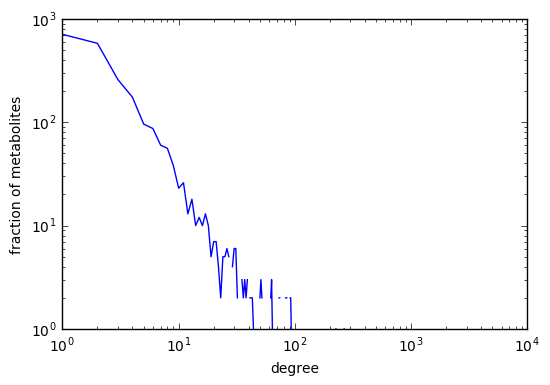

In [6]:
import matplotlib.pyplot as plt
degree, frac_metabolites = zip(*[(left, count) for left, _, count in meta_graph.degree_distribution(1, vertices=metabolite_idx).bins()])
plt.loglog(degree, frac_metabolites)
plt.xlabel("degree")
plt.ylabel("fraction of metabolites")
plt.show()

Q. Is the degree distribution well-described by a power law?

A. Yes, it is well-described by a power law because the degree distribution closely follows a straight line.

Step 5. Calculate the exponent α of the best-fit power-law.

In [9]:
power_law_fit(frac_metabolites).alpha

1.7611613665992407

Q. Compare the α to the estimate of the power-law exponent reported by Jeong at al. Is it appropriate to compare the exponents?

A. The α (=2.79) here is similar to the α (=2.2) reported by Jeong at al., as both follow the typical range between 2 to 3. Although the structure of the network is different in terms of reactions existence, the degree distribution of each metabolite will be similar because reactions can be regarded as bridges between metabolites. Therefore, I think it is appropriate to compare the exponents no matter if there are reactions or not in the networks.

Step 6. Calculate the shortest-path-length between all pairs of metabolites in the directed graph.

In [10]:
shortest_paths = meta_graph.shortest_paths(source=metabolite_idx, target=metabolite_idx, mode=ALL)
inf_idx = np.where(np.isinf(shortest_paths[0])==True)
print shortest_paths[0][inf_idx[0][0]]

inf


Q. Why are some of these path lengths infinite?

A. If a pair of metabolites are located in each separated component, their path becomes infinite.

Step 7. Calculate the average of the shortest-path-length between all pairs of metabolites in the giant (weakly connected) component of the network, by throwing away any shortest-paths distance value if it is infinite.

In [11]:
metabolite_cluster = meta_graph.clusters(mode='weak')
giant_cluster = metabolite_cluster.giant()
giant_memnbers = []
for v in giant_cluster.vs:
	if 'REACTION' in v['name']:
		continue
	else:
		giant_memnbers.append(v.index)
        
short_path_giant = np.array(giant_cluster.shortest_paths(source=giant_memnbers, target=giant_memnbers, mode=ALL))
short_path_giant = short_path_giant[np.isfinite(short_path_giant)]
np.average(short_path_giant)

6.7959448471365356

Step 8. Calculate the maximum of the shortest-path-length between all pairs of metabolites in the giant (weakly connected) component of the network (= calculating the diameter of the giant component)

In [12]:
np.amax(short_path_giant)

18

Q. Why are the distances that we get, roughly twice those by Jeong?

A. I think it's because all metabolites are connected throughout the reactions. Therefore, the diameter we get is twice larger than those by Jeong, including reaction paths between metabolites.

Step 9. Calculate the shortest-paths betweeness centrality for all metabolites in the network.

In [13]:
betweeness = np.array(meta_graph.betweenness(vertices=metabolite_idx, directed=True))

Step 10. Plot the scatter plot of betweenness centrality vs. vertex degree for all metabolites on log-log scale.

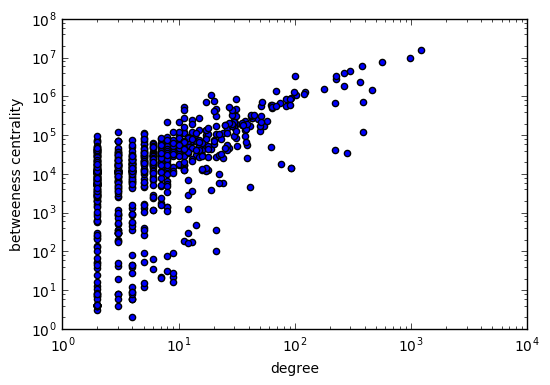

In [14]:
degree = np.array(meta_graph.degree(vertices=metabolite_idx))
inds_keep = np.where(betweeness > 0)
ax = plt.gca()
ax.scatter(degree[inds_keep], betweeness[inds_keep])
ax.loglog()
plt.xlabel("degree")
plt.ylabel("betweeness centrality")
plt.show()

Step 11. Among metabolites with degree k=2 , what metabolite has highest betweenness centrality in the network?

In [15]:
metabolites_degree_two = np.where(degree == 2)[0]
max_arg = np.argmax(betweeness[metabolites_degree_two])
metabolites_idx_max_betweenness = metabolite_idx[metabolites_degree_two[max_arg]]
print meta_graph.vs[metabolites_idx_max_betweenness]["name"]

L-arginino-succinate


Q. What important metabolic cycle is the enzyme involved in? What is the known consequence of a mutation in this gene, from a health standpoint?

A. L-arginino-succinate is catalyzed by Argininosuccinate synthase enzyme. This enzyme is involved in the urea cycle, and a mutation in this gene can cause liver or kidney cancers.  